In [2]:
import numpy as np
import glob
import os
import pandas as pd
import pickle
import scipy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline  

from tqdm import tqdm
from sklearn.discriminant_analysis import _cov
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from scipy import stats
from statsmodels.stats import multitest
from mne.datasets import sample
from mne.decoding import (SlidingEstimator, GeneralizingEstimator, Scaler,
                          cross_val_multiscore, LinearModel, get_coef,
                          Vectorizer, CSP)
from scipy import stats
from statsmodels.stats import multitest
from itertools import groupby

In [3]:
files = glob.glob(r'E:/Projects/2020_recurrentprocessing/Analysis/scores localizer continuous time points/*22_oc_60_011721*')
print(f'There are {len(files)} participants')

There are 58 participants


In [4]:
data = pd.DataFrame()
for pp in range(len(files)):
    f = open(files[pp], 'rb')
    
    data2append = pickle.load(f)
    de_mat=np.zeros((152, 8))

    for condition in range(8):   
        de_mat[:,condition]=np.diag(data2append[:,:,condition])
        
    df2append = pd.DataFrame(de_mat)
    df2append['ppn']=pp
    data=data.append(df2append)

data.index.name = 'timepoint'
data = data.reset_index()
data.rename(columns={0: "segmented - unmasked", 1 : "low - unmasked", 2 : "med - unmasked", 3 : "high - unmasked", 4 : "segmented - masked", 5 : "low - masked" , 6 : "med - masked", 7: "high - masked"},inplace=True)
data= pd.melt(data, id_vars=['timepoint', 'ppn'], value_vars=['segmented - unmasked', 'low - unmasked', 'med - unmasked', 'high - unmasked','segmented - masked', 'low - masked', 'med - masked', 'high - masked'])

data[['Complexity','Masking']] = data.variable.str.split("-",expand=True,)
data.head(10)


,timepoint,ppn,variable,value,Complexity,Masking
0,0,0,segmented - unmasked,0.219298,segmented,unmasked
1,1,0,segmented - unmasked,0.245614,segmented,unmasked
2,2,0,segmented - unmasked,0.254386,segmented,unmasked
3,3,0,segmented - unmasked,0.210526,segmented,unmasked
4,4,0,segmented - unmasked,0.184211,segmented,unmasked
5,5,0,segmented - unmasked,0.219298,segmented,unmasked
6,6,0,segmented - unmasked,0.236842,segmented,unmasked
7,7,0,segmented - unmasked,0.184211,segmented,unmasked
8,8,0,segmented - unmasked,0.210526,segmented,unmasked
9,9,0,segmented - unmasked,0.201754,segmented,unmasked


In [5]:
import seaborn as sns

In [6]:
data.shape
print(data['Masking'].unique())
print(data['Complexity'].unique())


[' unmasked' ' masked']
['segmented ' 'low ' 'med ' 'high ']


In [7]:
result = pd.DataFrame()
all_results=pd.DataFrame()

for masking in data['Masking'].unique():
    for condition in data['Complexity'].unique():
        data4stats = data[(data['Masking']==masking) & (data['Complexity']==condition)]
        
        pVals = []

        for t in range(0,152):
            
            _, p = stats.wilcoxon(data4stats[data4stats['timepoint']==t]['value']-0.2)
            pVals.append(p)
            
        if len(all_results)==0:
            all_results['pvals'] = pd.Series(pVals)        
            all_results['masking']=masking 
            all_results['condition']=condition.strip()
            all_results['against']="chance"
        else: 
            result['pvals'] = pd.Series(pVals)        
            result['masking']=masking 
            result['condition']=condition.strip()
            result['against']="chance"
            all_results = pd.concat((all_results,result),axis=0)
all_results.to_csv('onsets.csv')


In [8]:
result = pd.DataFrame()

for masking in data['Masking'].unique():
    x = ['high ', 'high ', 'high ', 'med ', 'med ', 'low ']
    y = ['segmented ', 'low ', 'med ', 'segmented ', 'low ', 'segmented ']
    for i in range(6):
        data4stats = data[(data['Masking']==masking) & (data['Complexity']==x[i])]
        data4comp = data[(data['Masking']==masking) & (data['Complexity']==y[i])]
              
        pVals = []

        for t in range(0,152):
            
            _, p = stats.wilcoxon(data4stats[data4stats['timepoint']==t]['value'], data4comp[data4comp['timepoint']==t]['value'])
            pVals.append(p)
            
        if len(all_results)==0:
            print("something's wrong")
            all_results['pvals'] = pd.Series(pVals)        
            all_results['masking']=masking 
            all_results['condition']=x[i].strip()
            all_results['against']=y[i].strip()
        else: 
            result['pvals'] = pd.Series(pVals)        
            result['masking']=masking 
            result['condition']=x[i].strip()
            result['against']=y[i].strip()
            all_results = pd.concat((all_results,result),axis=0)


In [9]:
print(all_results)
sig, pVals_corr = multitest.fdrcorrection(all_results['pvals'],0.01)
all_results['sig'] = sig
all_results['pVals_corr']= pVals_corr

        pvals    masking  condition    against
0    0.213618   unmasked  segmented     chance
1    0.569040   unmasked  segmented     chance
2    0.311887   unmasked  segmented     chance
3    0.543083   unmasked  segmented     chance
4    0.972165   unmasked  segmented     chance
..        ...        ...        ...        ...
147  0.052653     masked        low  segmented
148  0.274766     masked        low  segmented
149  0.454393     masked        low  segmented
150  0.537181     masked        low  segmented
151  0.382570     masked        low  segmented

[3040 rows x 4 columns]


In [10]:
## define coordinates for plotting significance bars
sigbar = {"segmented": 0.173, "low": 0.169, "med": 0.165, "high":0.161}
difbar = {"highsegmented": 0.263, "highlow": 0.259, "medsegmented": 0.255, "medlow":0.251}
all_results = all_results.rename_axis('timepoint').reset_index()
all_results['yval']=all_results['condition'].map(sigbar)
all_results['diff']=all_results['condition']+all_results['against']
all_results['yval_diff']=all_results['diff'].map(difbar)
sig = all_results[all_results['sig']==True]


In [11]:
numbers = [0, 100,200,300, 400, 500, 600]

font = {'family': 'sans-serif',
        'color':  'black',
        'weight': 'light',
        'size': 16,
        }

fontxs = {'family': 'sans-serif',
        'color':  'black',
        'weight': 'light',
        'size': 12,
        }

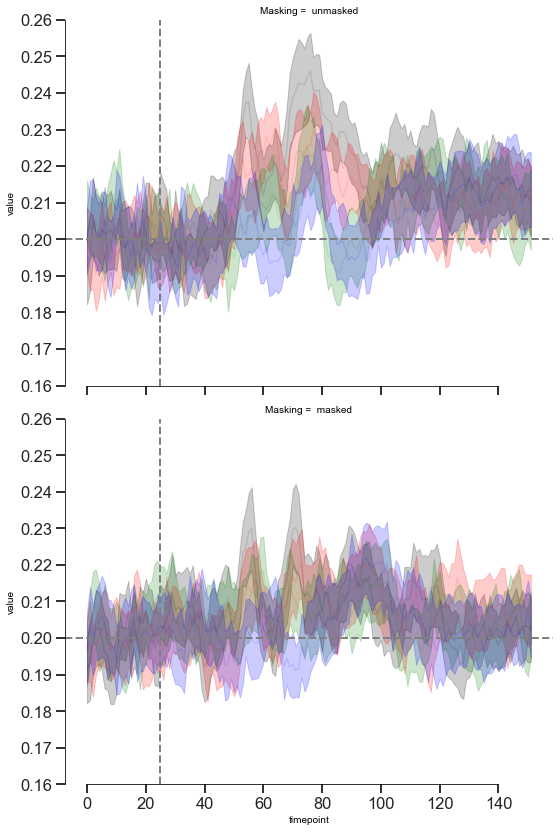

In [12]:
# Plot the responses for different events and regions
erp_plot = sns.relplot(x="timepoint", y="value",ci=95,
             hue="Complexity", row="Masking",kind="line",# style="event",
            palette = ['black', 'red', 'green', 'blue'],alpha=0.2 if (all_results['sig']==True).all() else 0.1,
                       legend=False, markers = 'True' if (all_results['sig'] ==True).all() else 'False',
             data=data)

erp_plot.set(ylim=(0.16, 0.26))
erp_plot.set(yticks=[0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26])
erp_plot.fig.set_figwidth(8.27)
erp_plot.fig.set_figheight(11.7)


for ax in erp_plot.axes.flat:
    ax.axvline(25, ls='--', linewidth=2, color="gray")
    ax.axhline(0.2, ls='--', linewidth=2, color="gray")

sns.set(style="ticks")
sns.set_context('talk')
sns.color_palette("Paired")
sns.despine(offset=0, trim=True)

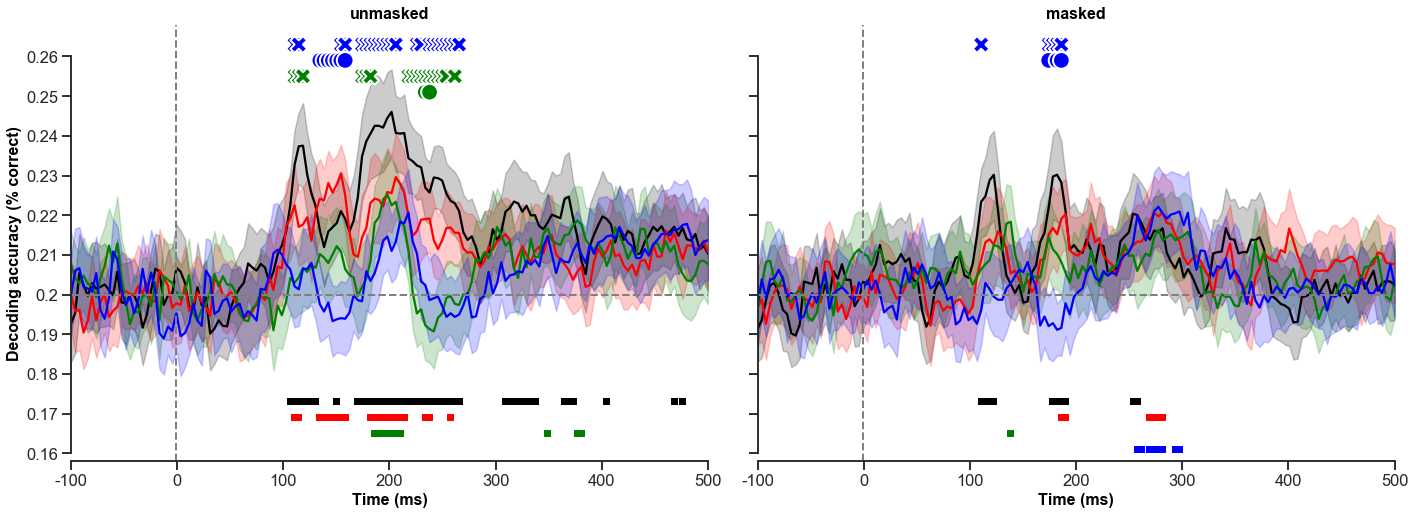

In [13]:

f, (ax1, ax2) = plt.subplots(1,2,figsize=(20,7.5),sharey=True)

# Show each observation with a scatterplot
sns.lineplot(x="timepoint", y="value",ci=95,
             hue="Complexity", 
            palette = ['black', 'red', 'green', 'blue'],
                       legend=False,
             data=data[data['Masking']==" unmasked"], ax=ax1)

sns.scatterplot(x="timepoint", y='yval',
              data=sig[(sig['masking']==' unmasked') & (sig['against']=='chance')],
              palette = ['black', 'red', 'green'],legend=False, linewidth=0,s=50,
              #kind="scatter",ax=ax,dodge=True, 
              hue="condition", marker = "s", ax=ax1)

sns.scatterplot(x="timepoint", y='yval_diff',
              data=sig[(sig['masking']==' unmasked') & (sig['against']!='chance')],
              palette = ['blue', 'blue', 'green', 'green'],legend=False,linewidth=2,
              #kind="scatter",ax=ax,
              markers=['X', 'o', 'X', 'o'],s=280,
              hue = 'diff',style='diff' ,ax=ax1)

# Show each observation with a scatterplot
sns.lineplot(x="timepoint", y="value",ci=95,
             hue="Complexity", 
            palette = ['black', 'red', 'green', 'blue'],
                       legend=False,
             data=data[data['Masking']==" masked"], ax=ax2)

sns.scatterplot(x="timepoint", y='yval',
              data=sig[(sig['masking']==' masked') & (sig['against']=='chance')],
              palette = ['black', 'red', 'green', 'blue'],legend=False,marker = "s", linewidth=0,s=50,
              #kind="scatter",ax=ax,dodge=True,
              hue="condition", ax=ax2)

sns.scatterplot(x="timepoint", y='yval_diff',
              data=sig[(sig['masking']==' masked') & (sig['against']!='chance')],linewidth=2,
              palette = ['blue', 'blue'],legend=False,
              #kind="scatter",ax=ax,
              markers=['X', 'o'],s=280,
              hue="diff",style='diff' ,ax=ax2)


ax1.set(ylim=(0.158, 0.268))
ax1.set(yticks=[0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26])
ax1.set_yticklabels([0.16, 0.17, 0.18, 0.19, 0.20, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26], fontdict=font)


ax1.set(xlim=(0,151))
ax1.set(xticks=[number /(600/151) for number in numbers])
ax1.set_xticklabels(['-100','0','100','200','300','400','500'], fontdict=font)
ax1.set_title('unmasked', fontweight="bold", fontdict=font)
ax1.set_xlabel('Time (ms)', fontweight="bold", fontdict=font)
ax1.set_ylabel('Decoding accuracy (% correct)', fontweight="bold", fontdict=font)

ax2.set(xlim=(0,151))
ax2.set(xticks=[number /(600/151) for number in numbers])
ax2.set_xticklabels(['-100','0','100','200','300','400','500'], fontdict=font)
ax2.set_title('masked',fontweight="bold", fontdict=font)
ax2.set_xlabel('Time (ms)', fontweight="bold", fontdict=font)

ax1.axvline(25, ls='--', linewidth=2, color="gray")
ax1.axhline(0.2, ls='--', linewidth=2, color="gray")

ax2.axvline(25, ls='--', linewidth=2, color="gray")
ax2.axhline(0.2, ls='--', linewidth=2, color="gray")


sns.set(style="ticks")
sns.set_context('talk')
sns.color_palette("Paired")
sns.despine(offset=0, trim=True)

plt.tight_layout()
plt.show()

In [14]:
sig.to_csv('stats.csv')